# Single-Trial Classification

In [1]:
import numpy as np
import mne
import os 
import re
import matplotlib.pyplot as plt
%matplotlib inline

from util.stats import get_binomial_test
from mne.stats import fdr_correction
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import balanced_accuracy_score, accuracy_score, make_scorer
from mne.decoding import (cross_val_multiscore, LinearModel,
                          SlidingEstimator, get_coef)

# set seed for reproducibility 
np.random.seed(0)

# hard-coded values
CONDS = "fundedAndUnfunded"
EPOCHS_DIR = "epoched_data"

In [2]:
# get subject files
fnames = [f for f in os.listdir(EPOCHS_DIR) if CONDS in f]
subj_nums = [re.search("\d+", f).group(0) for f in fnames]

# load in data
eeg = []
subj_idx = [] # keeps track of which trial belongs to which subj
trial_cts = []
for i in range(len(subj_nums)):
    epochs = mne.read_epochs(os.path.join(EPOCHS_DIR, fnames[i]), verbose = False)
    n_trials = epochs.events.shape[0]
    subj_idx += n_trials*[subj_nums[i]]
    trial_cts.append(n_trials)
    eeg.append(epochs)
eeg = mne.concatenate_epochs(eeg)

# and format for classification
X = eeg.get_data() 
y = eeg.events[:, 2]

For classification, we implement logistic regression with an L2 penalty for regularization, i.e. logistic ridge regression. The weight of the penalty term (or strength of the regularizer) is determined as part the training procedure; it is set to whichever value maximizes stratified 10-folds cross-validation accuracy on the training set. The model is independently fit at each time point, hence "`SlidingEstimator`".

In [3]:
# define model pipeline
logistic_ridge = LogisticRegressionCV(solver = 'lbfgs', cv = 10, penalty = 'l2')
clf = make_pipeline(StandardScaler(), LinearModel(logistic_ridge))
scorer = make_scorer(accuracy_score, normalize = False) # gets number correct
time_decod = SlidingEstimator(clf, n_jobs = 1, scoring = scorer, verbose = True)

To evaluate our classification performance, we train a model on all subjects but one and test on the one we left out. We do this $n$ times, where $n$ is the number of subjects, leaving a different subject out each time. We call this "leave-one-subject-out cross-validation." By measuring model accuracy only on examples the model hasn't seen during traing, we can get an idea of how well the model will perform on _new_ subjects.

In [4]:
# evaluate leave-one-subject-out cross-validation accuracy
cv_methd = LeaveOneGroupOut()
scores = cross_val_multiscore(time_decod, X, y, groups = subj_idx, cv = cv_methd, n_jobs = 3)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  16 out of  16 | elapsed: 83.7min finished


We subject the testing accuracy, across all cross-validation splits, to a binomial test to determine if classification accuracy is greater than chance. Since we do this at every time point, we correct for multiple comparisons by controlling the false discovery rate (FDR) to 5% using the Benjamini–Hochberg procedure.

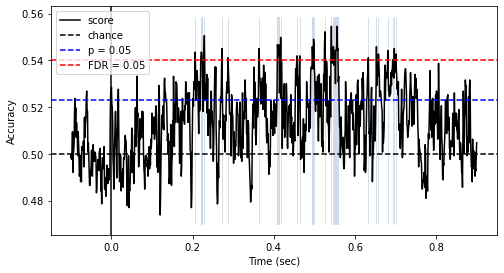

In [5]:
# compute accuracy across cross-validation splits
n_correct = scores.sum(0)
accuracies = n_correct/sum(trial_cts)

# test each time point against chance accuracy
binom_test = get_binomial_test(sum(trial_cts))
p = binom_test(n_correct)
# Benjamini–Hochberg correction for multiple comparisons
reject, _ = fdr_correction(p) 
corrected_thresh = min(accuracies[reject])
uncorrected_thresh = max(accuracies[p > .05])

# visualize cross-validation accuracy over time
fig, ax = plt.subplots( figsize=(8, 4.2))
ax.plot(epochs.times, accuracies, label='score', color = "black")
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axhline(uncorrected_thresh, color='blue', linestyle='--', label= 'p = 0.05')
ax.axhline(corrected_thresh, color='red', linestyle='--', label = 'FDR = 0.05')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Accuracy')  
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('')
ax.fill_between(epochs.times, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = reject, color = 'lightsteelblue', alpha=0.5)

Regions in which cross-validation accuracy exceeds the FDR threshold are shaded on the plot above.

In [6]:
max(p[reject]) # FDR corrected alpha

0.0022403503604685976

In [7]:
# train on full dataset to get final model weights
time_decod.fit(X, y)

<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel',
                 LinearModel(model=LogisticRegressionCV(cv=10)))]),
         n_jobs=1, scoring=make_scorer(accuracy_score, normalize=False),
         verbose=True, fitted with 1001 estimators>

No projector specified for this dataset. Please consider the method self.add_proj.


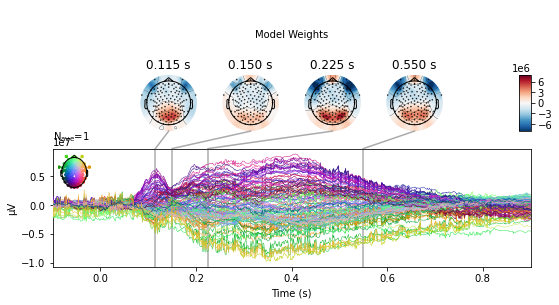

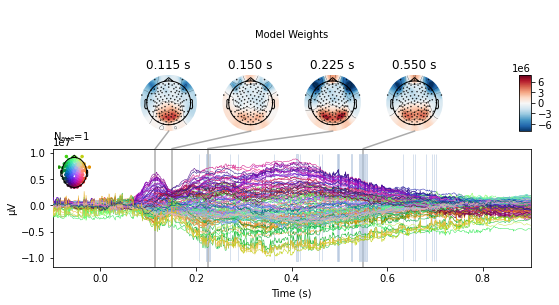

In [8]:
# visualize model weights
coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
fig = evoked_time_gen.plot_joint(times=np.array([.115, .150, .225, .550]), title = 'Model Weights',
                           **joint_kwargs)
ax = fig.axes[0] # axis for butterfly plot
ax.fill_between(epochs.times, ax.get_ylim()[0], ax.get_ylim()[1], 
                where = reject, color = 'lightsteelblue', alpha=0.5)
fig

The plot above shows how the model weights (the $\beta$s) evolve over time, with selected topographies shown graphically. These topographies show which electrodes are important to the model, _not_ the raw electrode values. Again, regions in which classification accuracy surpasses the FDR threshold are shaded. The $y$-axis says that units are in $\mu$V since we used a plot function meant for ERPs, but that is a lie.

In [9]:
evoked_time_gen.save("model.fif") # save model weights

<ipython-input-9-2e57d449b5e9>:1: RuntimeWarning: This filename (model.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked_time_gen.save("model.fif") # save model weights
